In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

dataset, info = tfds.load("imagenette", as_supervised=True, with_info=True) # Load the dataset
dataset_size = info.splits["train"].num_examples# Get number of examples in train set
class_names = info.features["label"].names # Class names from the dataset
n_classes = info.features["label"].num_classes # Number of classes

print("Number of Images: ",dataset_size)
print("Number of Classes:",n_classes)
print("Class Names:      ",class_names)

test_set, train_set = tfds.load(# Split the data into test and training sets
    "imagenette",
    split=["train[:25%]", "train[25%:]"],
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/9469 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0.incompleteYNPS1A/imagenette-train.tfrecord*.…

Generating validation examples...:   0%|          | 0/3925 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0.incompleteYNPS1A/imagenette-validation.tfrec…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/full-size-v2/1.0.0. Subsequent calls will reuse this data.
Number of Images:  9469
Number of Classes: 10
Class Names:       ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


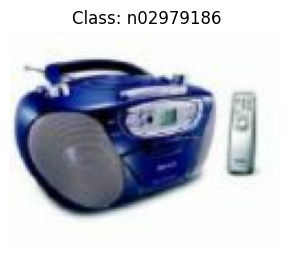

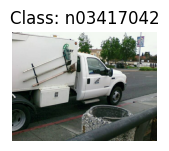

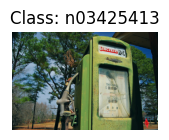

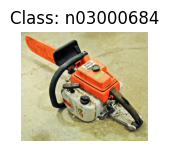

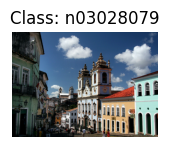

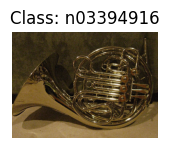

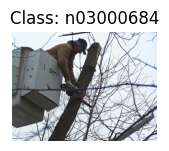

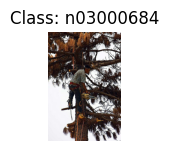

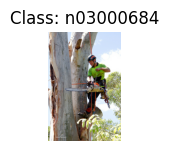

In [ ]:
plt.figure(figsize=(12, 10))# Create a figure to display images
index = 0
for image, label in test_set.take(9):# Iterate through first 9 samples in the test
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")
    plt.show()

In [ ]:
import tensorflow as tf
from tensorflow import keras

def preprocess(image, label):
    """
    The `preprocess` function resizes an image to 224x224 and preprocesses it using Xception model
    before returning the final image and its label.
    
    :param image: The `image` parameter is the input image data that you want to preprocess
    :param label: The `label` parameter typically refers to the class label or category associated with
    the image. It is often used in machine learning tasks, such as image classification, to indicate the
    correct category or class that the image belongs to
    :return: The preprocess function returns the final preprocessed image and the original label.
    """
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32# Define the batch size for training and testing
train_set = train_set.shuffle(1000)#  Shuffles the dataset by randomly interleaving
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)#
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

print("Done")

Done


In [ ]:
# Build the base Xception model without the top layers
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)# Use Global Averaging Pooling (GAP) to reduce dimensionality of features
output = keras.layers.Dense(n_classes, activation="softmax")(avg)# Adds a softmax layer on top of the average pooling layer
model = keras.models.Model(inputs=base_model.input, outputs=output)# Print out some information about the model

for layer in base_model.layers:# Loop over each of the base model's layers
    layer.trainable = False

model.summary()# Print out a summary of the base model


83683744/83683744 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  

In [ ]:
print()
print("Training Report (base layers frozen)...")
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)# Set up optimizer
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])# Compile the model
history = model.fit(train_set, epochs=5)# Train the model on the training set

print()
print("Accuracy on Test Set...")
model.evaluate(test_set)# Evaluate the accuracy of the model on the test set



Training Report (base layers frozen)...
Epoch 1/5
222/222 [==============================] - 48s 168ms/step - loss: 0.0928 - accuracy: 0.9762
Epoch 2/5
222/222 [==============================] - 36s 153ms/step - loss: 0.0155 - accuracy: 0.9954
Epoch 3/5
222/222 [==============================] - 34s 146ms/step - loss: 0.0042 - accuracy: 0.9989
Epoch 4/5
222/222 [==============================] - 34s 146ms/step - loss: 0.0025 - accuracy: 0.9996
Epoch 5/5
222/222 [==============================] - 34s 147ms/step - loss: 0.0018 - accuracy: 1.0000

Accuracy on Test Set...
74/74 [==============================] - 15s 188ms/step - loss: 0.0289 - accuracy: 0.9920


[0.028863659128546715, 0.9919729828834534]

In [ ]:
for layer in base_model.layers:# Unfreeze all of the base model's
    layer.trainable = True

print()
print("Training Report (fine tune)...")
optimizer = keras.optimizers.legacy.SGD(learning_rate=0.001, momentum=0.9, decay=0.001)# Re-setup optimizer
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])# Compile the model with new loss function and optim
history = model.fit(train_set, epochs=5)# Fine tune the model on the training set

print()
print("Accuracy on Test Set...")
model.evaluate(test_set)# Get the evaluation results on the test set


Training Report (fine tune)...
Epoch 1/5
222/222 [==============================] - 114s 483ms/step - loss: 0.0032 - accuracy: 0.9994
Epoch 2/5
222/222 [==============================] - 117s 519ms/step - loss: 0.0015 - accuracy: 0.9999
Epoch 3/5
222/222 [==============================] - 117s 520ms/step - loss: 0.0025 - accuracy: 0.9996
Epoch 4/5
222/222 [==============================] - 117s 520ms/step - loss: 9.7575e-04 - accuracy: 0.9999
Epoch 5/5
222/222 [==============================] - 118s 523ms/step - loss: 0.0016 - accuracy: 0.9997

Accuracy on Test Set...
74/74 [==============================] - 12s 144ms/step - loss: 0.0424 - accuracy: 0.9869


[0.04237106069922447, 0.9869032502174377]